# Planning

## Challenge
This is an open-ended challenge to basically come up with something interesting and useful (with a business case!) from the given dataset. Some suggestions include identifying trends or actionable insights, or providing recommendations. The audience could be restaurant customers, inspectors, or restauranteurs.

## Approach
- Read data dictionary and accompanying documentation
- Read in and clean the data
    - Fill in missing grade where relevant
- Plot everything
- Add derived variables
    - Gradeable/non-gradeable inspection
    - Get month, year, day components of inspection date
- Make a plan for what I will do


## Results

## Takeaways

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from datetime import datetime

sns.set_style("whitegrid")

In [2]:
data_dir = '~/devel/insight-data-challenges/05-nyc-restaurant-inspections/data'

## Read in and clean the user data

In [3]:
inspections = pd.read_csv(
    os.path.join(os.path.expanduser(data_dir), 'DOHMH_New_York_City_Restaurant_Inspection_Results.csv'),
    parse_dates=['INSPECTION DATE', 'GRADE DATE', 'RECORD DATE']
)

print(inspections.info())

with pd.option_context('display.max_columns', 100):
    print(inspections.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401215 entries, 0 to 401214
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   CAMIS                  401215 non-null  int64         
 1   DBA                    400833 non-null  object        
 2   BORO                   401215 non-null  object        
 3   BUILDING               400952 non-null  object        
 4   STREET                 401214 non-null  object        
 5   ZIPCODE                395737 non-null  float64       
 6   PHONE                  401198 non-null  object        
 7   CUISINE DESCRIPTION    401215 non-null  object        
 8   INSPECTION DATE        401215 non-null  datetime64[ns]
 9   ACTION                 399879 non-null  object        
 10  VIOLATION CODE         395597 non-null  object        
 11  VIOLATION DESCRIPTION  392214 non-null  object        
 12  CRITICAL FLAG          392214 non-null  obje

### Fix data types

Find the categorical variables

In [4]:
# Are there any that look categorical based on number of unique values?
values_per_variable = inspections.apply('nunique', 0)
variable_dtypes = inspections.dtypes.apply(lambda x: x.name)
variable_info = pd.DataFrame({'n_categories': values_per_variable,
                              'dtype': variable_dtypes,
                              'variable': values_per_variable.index}).reset_index(drop=True)
print(variable_info)

# Convert columns to categorical
cat_threshold = 110  # If n unique values is below this, it's probably categorical
known_cat_cols = [
    'ACTION', 'BORO', 'GRADE', 'INSPECTION TYPE', 'CRITICAL FLAG', 'CUISINE DESCRIPTION',
    'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'Community Board', 'Council District'
]

variable_info['to_category'] = (variable_info['n_categories'] < cat_threshold)\
                               & (~variable_info['dtype'].isin(('datetime64[ns]', )))
print(variable_info)
# Are there any known categorical variables missing? Or vice versa?
set(variable_info['variable'].loc[variable_info['to_category']].to_list()) - set(known_cat_cols)
set(known_cat_cols) - set(variable_info['variable'].loc[variable_info['to_category']].to_list())

for v in variable_info['variable'].loc[variable_info['to_category']]:
    inspections[v] = inspections[v].astype('category')

print(inspections.info())
variable_info['dtype'] = inspections.dtypes.apply(lambda x: x.name).to_numpy()

    n_categories           dtype               variable
0          27308           int64                  CAMIS
1          21611          object                    DBA
2              6          object                   BORO
3           7307          object               BUILDING
4           3239          object                 STREET
5            226         float64                ZIPCODE
6          25552          object                  PHONE
7             84          object    CUISINE DESCRIPTION
8           1341  datetime64[ns]        INSPECTION DATE
9              5          object                 ACTION
10           104          object         VIOLATION CODE
11            89          object  VIOLATION DESCRIPTION
12             2          object          CRITICAL FLAG
13           136         float64                  SCORE
14             7          object                  GRADE
15          1272  datetime64[ns]             GRADE DATE
16             1  datetime64[ns]            RECO

### Convert zipcode to an int

In [5]:
inspections['ZIPCODE'].describe()
inspections['ZIPCODE'].isna().sum()  # 5500 NaN values, which is why it's not an int. Leave it for now.

5478

Fix missing value codes

In [6]:
inspections['BORO'] = inspections['BORO'].replace('0', np.NaN)

for v in inspections.select_dtypes(include='category').columns:
    print('_' * 20)
    print(v)
    with pd.option_context('display.max_rows', cat_threshold):
        print(inspections[v].value_counts(dropna=False))

new_establishment_inspection_date = datetime(1900, 1, 1)
inspections['INSPECTION DATE'] = inspections['INSPECTION DATE'].replace(new_establishment_inspection_date, pd.NaT)

for v in inspections.select_dtypes(include='datetime').columns:
    print('_' * 20)
    print(v)
    with pd.option_context('display.max_rows', cat_threshold):
        print(inspections[v].value_counts(dropna=False))

with pd.option_context('display.max_columns', 100):
    print(inspections.select_dtypes(include='number').describe())

variable_info['n_missing'] = inspections.apply(lambda x: x.isna().sum()).to_numpy()

____________________
BORO
Manhattan        158069
Brooklyn         101968
Queens            91487
Bronx             36178
Staten Island     13435
NaN                  78
Name: BORO, dtype: int64
____________________
CUISINE DESCRIPTION
American                                                            83714
Chinese                                                             42261
Café/Coffee/Tea                                                     19734
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    17661
Pizza                                                               17412
Mexican                                                             16654
Italian                                                             16206
Japanese                                                            14566
Caribbean                                                           14447
Spanish                                                             12548
Bakery                  

              CAMIS        ZIPCODE          SCORE       Latitude  \
count  4.012150e+05  395737.000000  384379.000000  400798.000000   
mean   4.619473e+07   10678.272221      20.414005      40.171996   
std    4.397160e+06     596.579121      14.856352       4.728947   
min    3.007544e+07   10000.000000      -1.000000       0.000000   
25%    4.140075e+07   10022.000000      11.000000      40.685816   
50%    5.000831e+07   10468.000000      15.000000      40.732431   
75%    5.005914e+07   11229.000000      26.000000      40.761813   
max    5.010429e+07   12345.000000     164.000000      40.912822   

           Longitude   Census Tract           BIN           BBL  
count  400798.000000  395333.000000  3.935720e+05  4.007980e+05  
mean      -72.932686   28759.335320  2.508252e+06  2.402582e+09  
std         8.584902   30484.225747  1.349706e+06  1.341219e+09  
min       -74.248520     100.000000  1.000000e+06  1.000000e+00  
25%       -73.989243    7800.000000  1.043046e+06  1.0104

## Add some derived variables

### Use documentation instructions to label gradeable/ungradeable inspections

In [7]:
gradeable_inspection_types = (
    'Cycle Inspection/Initial Inspection',
    'Cycle Inspection/Re-Inspection',
    'Pre-Permit (Operational)/Initial Inspection',
    'Pre-Permit (Operational)/Re-Inspection',
)
gradeable_actions = (
    'Violations were cited in the following area(s)',
    'No violations were recorded at the time of this inspection',
    'Establishment Closed by DOHMH',
)
gradeable_inspection_date_min = datetime(2010, 7, 27)

inspections['is_gradeable'] = ((inspections['INSPECTION TYPE'].isin(gradeable_inspection_types))
                               & (inspections['ACTION'].isin(gradeable_actions))
                               & (inspections['INSPECTION DATE'] >= gradeable_inspection_date_min)
                               )

### Add variables for date components

In [8]:
inspections['inspection_year'] = inspections['INSPECTION DATE'].dt.year.astype('category')
inspections['inspection_month'] = inspections['INSPECTION DATE'].dt.month.astype('category')
inspections['inspection_day'] = inspections['INSPECTION DATE'].dt.day
inspections['inspection_dayofyear'] = inspections['INSPECTION DATE'].dt.dayofyear
inspections['inspection_dayofweek'] = inspections['INSPECTION DATE'].dt.dayofweek.astype('category')
inspections['inspection_isweekday'] = inspections['inspection_dayofweek'].isin(range(5))
inspections['inspection_week'] = inspections['INSPECTION DATE'].dt.week.astype('category')
print(inspections.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401215 entries, 0 to 401214
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   CAMIS                  401215 non-null  int64         
 1   DBA                    400833 non-null  object        
 2   BORO                   401137 non-null  category      
 3   BUILDING               400952 non-null  object        
 4   STREET                 401214 non-null  object        
 5   ZIPCODE                395737 non-null  float64       
 6   PHONE                  401198 non-null  object        
 7   CUISINE DESCRIPTION    401215 non-null  category      
 8   INSPECTION DATE        399879 non-null  datetime64[ns]
 9   ACTION                 399879 non-null  category      
 10  VIOLATION CODE         395597 non-null  category      
 11  VIOLATION DESCRIPTION  392214 non-null  category      
 12  CRITICAL FLAG          392214 non-null  cate

## Plot everything

In [9]:
# Try the Pandas built in histogram function, even though it's mediocre
# inspections.hist()
# plt.show()
# And it fails on boolean columns!

### Histograms of the numeric variables

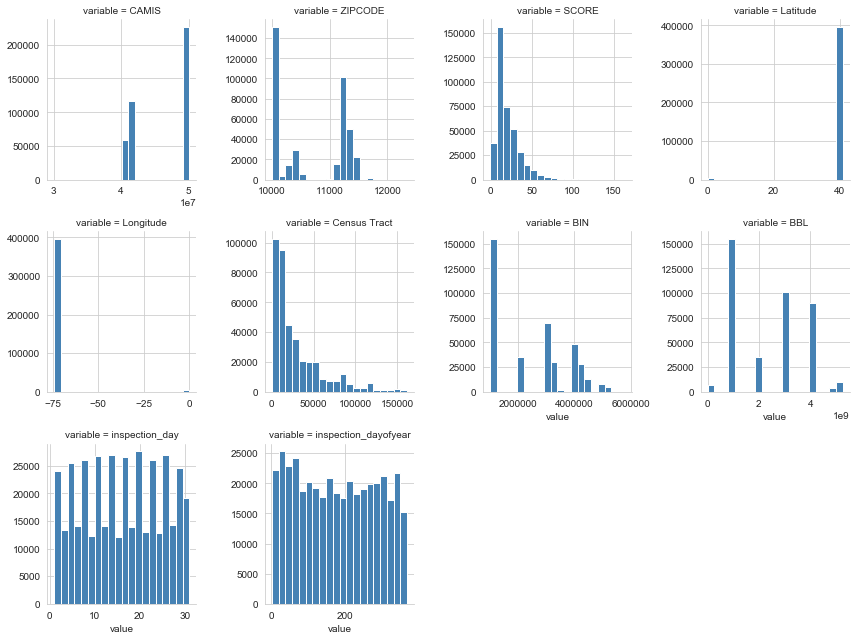

In [10]:
g = sns.FacetGrid(
    inspections.select_dtypes(include='number').melt(), col='variable', col_wrap=4,
    sharex=False, sharey=False
)
g.map(plt.hist, 'value', color='steelblue', bins=20)
plt.show()

### Barplots of the categorical & boolean variables

Individual plots for variables with too many categories

In [11]:
cat_col_n_values = inspections.select_dtypes(include='category').apply('nunique', 0)
many_values_cat_vars = cat_col_n_values.loc[cat_col_n_values > 20].index
other_cat_vars = cat_col_n_values.loc[cat_col_n_values <= 20].index

# for v in many_values_cat_vars:
#     g = sns.countplot(data=inspections, x=v)
#     g.set_xticklabels(g.get_xticklabels(), rotation=60, horizontalalignment='right')
#     plt.tight_layout()
#     plt.show()

# The best is really just a sorted table of value counts.
for v in many_values_cat_vars:
    print('_' * 20)
    print(v)
    with pd.option_context('display.max_rows', cat_threshold):
        print(inspections[v].value_counts(dropna=False))

____________________
CUISINE DESCRIPTION
American                                                            83714
Chinese                                                             42261
Café/Coffee/Tea                                                     19734
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    17661
Pizza                                                               17412
Mexican                                                             16654
Italian                                                             16206
Japanese                                                            14566
Caribbean                                                           14447
Spanish                                                             12548
Bakery                                                              12493
Pizza/Italian                                                        8328
Chicken                                                              76

A facet grid for those with fewer categories

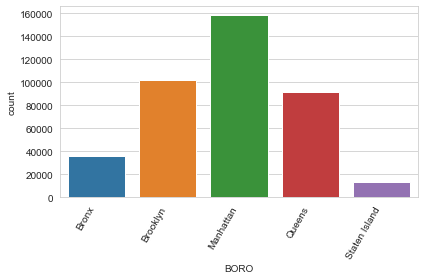

<ipython-input-12-7268e5fae820>:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


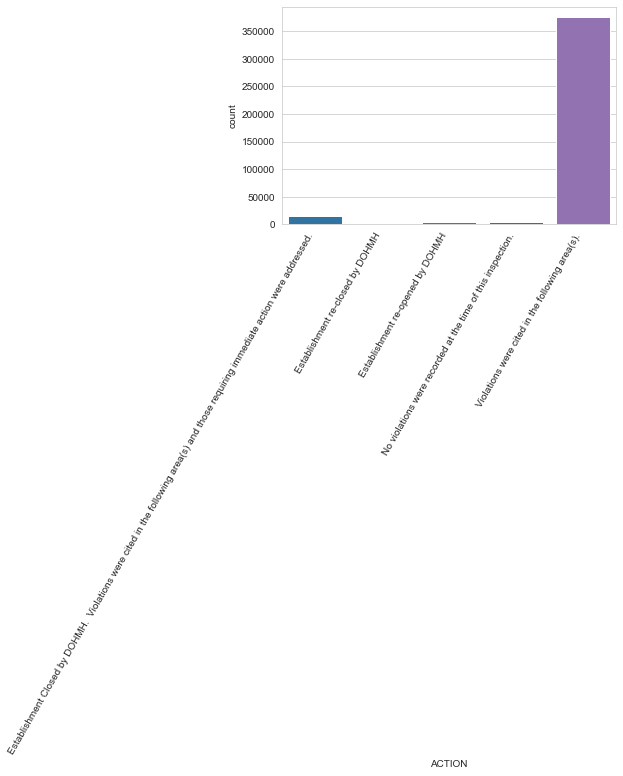

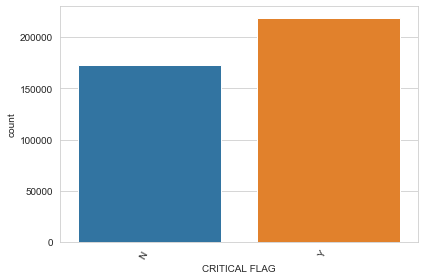

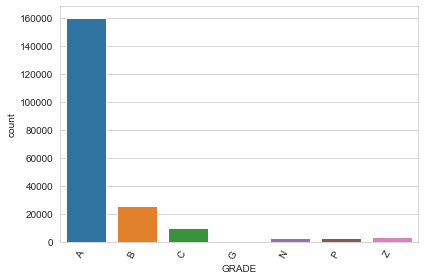

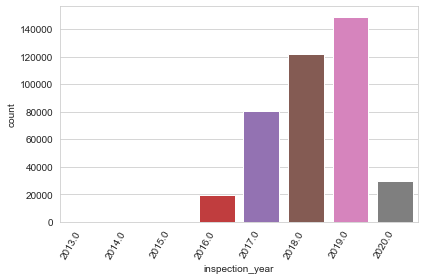

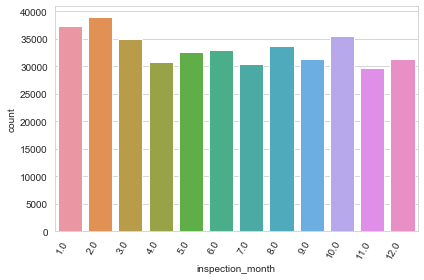

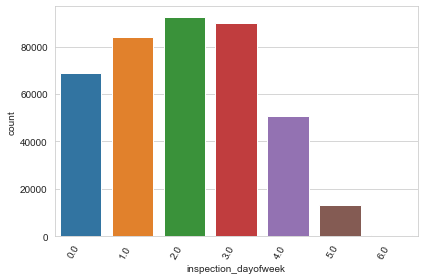

In [12]:
# tmp = inspections[other_cat_vars].melt()
# tmp['value_trunc'] = tmp['value'].str.slice(stop=25)
# g = sns.catplot(
#     data=tmp, col='variable', col_wrap=3,
#     x='value_trunc', kind='count',
#     facet_kws={'sharex': False, 'sharey': False},
#     margin_titles=False
# )
# for ax in g.axes.flat:
#     for label in ax.get_xticklabels():
#         label.set_rotation(70)
# plt.show()
# I can't get the sharex/sharey arguments to work properly. God do I miss ggplot!

for v in other_cat_vars:
    g = sns.countplot(data=inspections, x=v)
    g.set_xticklabels(g.get_xticklabels(), rotation=60, horizontalalignment='right')
    plt.tight_layout()
    plt.show()


### Scatter plot by index of the datetime variables

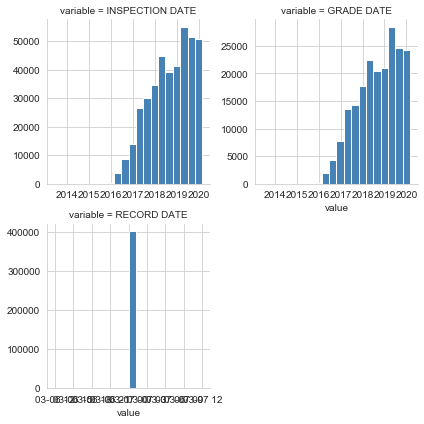

In [13]:
g = sns.FacetGrid(
    inspections.select_dtypes(include='datetime').melt(), col='variable', col_wrap=2,
    sharex=False, sharey=False
)
g.map(plt.hist, 'value', color='steelblue', bins=20)
plt.show()

### Head and tail of the object variables

In [14]:
for v in inspections.select_dtypes(include='object').columns:
    print('_' * 20)
    print(v)
    print(inspections[v].head(15))
    print(inspections[v].tail(15))

____________________
DBA
0                            GORILLA COFFEE
1        FIVE GUYS FAMOUS BURGERS AND FRIES
2               BLACK STONE COFFEE ROASTERS
3                               HAAGEN-DAZS
4                            TOKOYO EXPRESS
5                                    SBARRO
6                              DELI & GRILL
7                                 LA MESITA
8                                       ISE
9                            DOMINO'S PIZZA
10                             PICCOLO CAFE
11      FAMILY ALTAGRACIA CARIBBEAN CUISINE
12                               BAGELBERRY
13                            CHEF'S GARDEN
14    EL SABOR AZOGUENO BAKERY & RESTAURANT
Name: DBA, dtype: object
401200                                  DALLAS BBQ
401201                                 TEA STATION
401202                                  E SUSHI II
401203                                  SIDO GRILL
401204                                        MURA
401205    CITI FIELD WORLD'S FAIR M

## Summary of violations by establishment

## Summary of violations by type

References:

In [15]:
# This code is used to run the .py script from beginning to end in the python interpreter
# with open('python/nyc-restaurant-inspections.py', 'r') as f:
#     exec(f.read())

# plt.close('all')